# Simple linear regression 

Throughout the following exercises, you will learn to use Python to build a simple linear regression model. Before starting on this programming exercise, we strongly recommend watching the video lecture and completing the IVQ for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

As we move forward, you can find instructions on how to install required libraries as they arise in this notebook. Before we begin with the exercises and analyzing the data, we need to import all libraries and extensions required for this programming exercise. Throughout the course, we will be using pandas and statsmodels for operations, and seaborn for plotting.

## Relevant imports



Begin by importing the relevant packages and data.

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import stats
import math

In [2]:
# Load dataset
penguins = sns.load_dataset("penguins")

**sns datasets**:    
`get_dataset_names()`
|dataset|rows|columns|
|---|---|---|
|anagrams|20|5|
|anscombe|44|3|
|attention|60|5|
|brain_networks|923|63|
|car_crashes|51|8|
|diamonds|53940|10|
|dots|848|5|
|dowjones|649|2|
|exercise|90|6|
|flights|144|3|
|fmri|1064|5|
|geyser|272|3|
|glue|64|5|
|healthexp|274|4|
|iris|150|5|
|mpg|398|9|
|penguins|344|7|
|planets|1035|6|
|seaice|13175|2|
|taxis|6433|14|
|tips|244|7|
|titanic|891|15|

In [3]:
penguins.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female


In [4]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [6]:
penguins.shape

(344, 7)

From the first 5 rows of the dataset, we can see that there are several columns available: `species`, `island`, `bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`, and `sex`. There also appears to be some missing data.

## Data cleaning (not shown in videos)

For the purposes of this course, we are focusing our analysis on Adelie and Gentoo penguins, and will be dropping any missing values from the dataset. In a work setting, you would typically examine the data more thoroughly before deciding how to handle missing data (i.e., fill in, drop, etc.). Please refer back to previous program content if you need to review how to handle missing data.

In [7]:
for c in penguins.columns:
    print(f'{c} has {penguins.loc[:,c].isna().sum()} null values')

species has 0 null values
island has 0 null values
bill_length_mm has 2 null values
bill_depth_mm has 2 null values
flipper_length_mm has 2 null values
body_mass_g has 2 null values
sex has 11 null values


In [8]:
penguins[penguins.body_mass_g.isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


In [9]:
penguins.drop([3,339], inplace=True)

In [10]:
penguins.sex = penguins.sex.map({'Male':'M', 'Female':'F', np.nan: 'N'})

In [11]:
for c in penguins.columns:
    print(f'{c} has {penguins.loc[:,c].isna().sum()} null values')

species has 0 null values
island has 0 null values
bill_length_mm has 0 null values
bill_depth_mm has 0 null values
flipper_length_mm has 0 null values
body_mass_g has 0 null values
sex has 0 null values


In [12]:
penguins.rename(columns={'species':'Species'}).groupby('Species').agg(Count=pd.NamedAgg('island','count')).reset_index()

,Species,Count
0,Adelie,151
1,Chinstrap,68
2,Gentoo,123


You can review the documentation for [`dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) and [`reset_index()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html). In short, the `dropna()` function by default removes any rows with any missing values in any of the columns. The `reset_index()` function resets the index values for the rows in the dataframe. Typically, you use `reset_index()` after you've finished manipulating the dataset. By setting `inplace=True`, you will not create a new DataFrame object. By setting `drop=True`, you will not insert a new index column into the DataFrame object.

## Exploratory data analysis

In [13]:
df = penguins[(penguins.species!='Chinstrap') & (penguins.sex!='N')].reset_index(drop=True)
df.shape

(265, 7)

In [14]:
df.tail(1)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
264,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,M


Before you construct any model, it is important to get more familiar with your data. You can do so by performing exploratory data analysis or EDA. Please review previous program materials as needed if you would like to refamiliarize yourself with EDA concepts.

Since this part of the course focuses on simple linear regression, you want to check for any linear relationships among variables in the dataframe. You can do this by creating scatterplots using any data visualization package, for example `matplotlib.plt`, `seaborn`, or `plotly`.

To visualize more than one relationship at the same time, we use the `pairplot()` function from the `seaborn` package to create a scatterplot matrix.

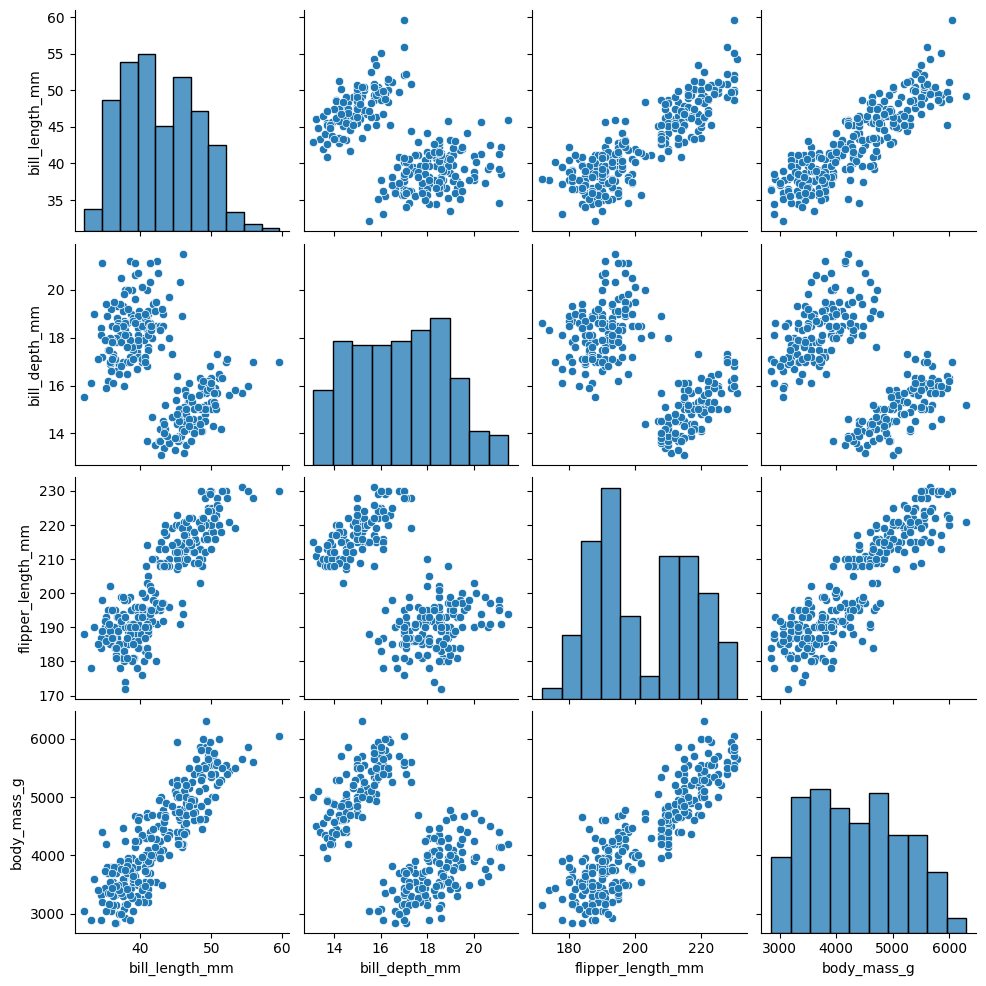

In [15]:
# Create pairwise scatterplots of data set
sns.pairplot(df)

From the scatterplot matrix, you can observe a few linear relationships:
* bill length (mm) and flipper length (mm)
* bill length (mm) and body mass (g)
* flipper length (mm) and body mass (g)

In [16]:
df[(df.species=='Gentoo')].head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
146,Gentoo,Biscoe,46.1,13.2,211.0,4500.0,F
147,Gentoo,Biscoe,50.0,16.3,230.0,5700.0,M
148,Gentoo,Biscoe,48.7,14.1,210.0,4450.0,F


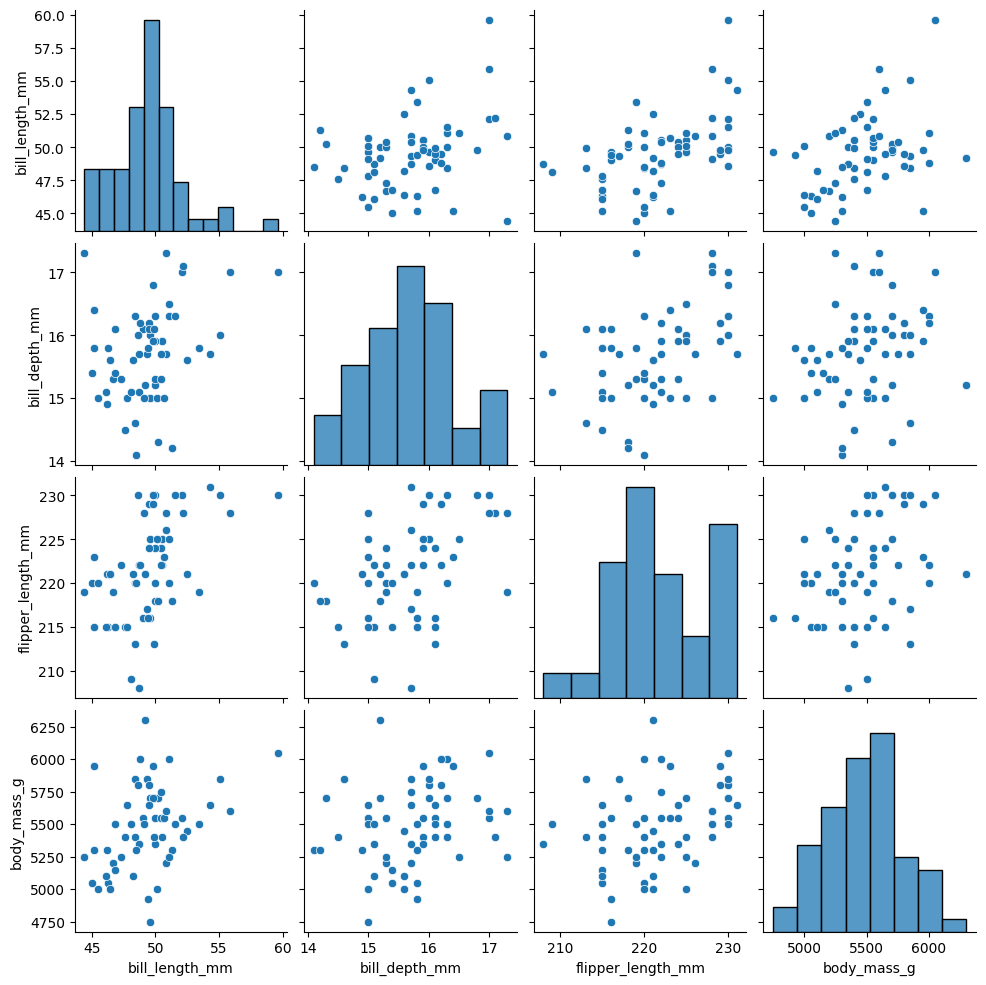

In [17]:
sns.pairplot(df[(df.species=='Gentoo')&(df.sex=='M')])

## Model construction



Based on the above scatterplots, you could probably run a simple linear regression on any of the three relationships identified. For this part of the course, you will focus on the relationship between bill length (mm) and body mass (g).

To do this, you will first subset the variables of interest from the dataframe. You can do this by using double square brackets `[[]]`, and listing the names of the columns of interest.

Next, you can construct the linear regression formula, and save it as a string.\
Remember that the y or dependent variable comes before the `~`, \
and the x or independent variables comes after the `~`.\
**Note:** The names of the x and y variables have to exactly match the column names in the dataframe.

In [18]:
# Import ols function
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
import statsmodels.api as sm

In [19]:
# Subset Data
ols_data = df[["bill_length_mm", "body_mass_g"]]

In [20]:
# Write out formula
ols_formula = "body_mass_g ~ bill_length_mm"

Lastly, you can build the simple linear regression model in `statsmodels` using the `ols()` function. You can import the `ols()` function directly using the line of code below.

Then, you can plug in the `ols_formula` and `ols_data` as arguments in the `ols()` function. After you save the results as a variable, you can call on the `fit()` function to actually fit the model to the data.

In [21]:
# Build OLS, fit model to data
OLS = ols(formula = ols_formula, data = ols_data)
model = OLS.fit()

Lastly, you can call the `summary()` function on the `model` object to get the coefficients and more statistics about the model. The output from `model.summary()` can be used to evaluate the model and interpret the results. Later in this section, we will go over how to read the results of the model output.

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     874.3
Date:                Sat, 20 Jul 2024   Prob (F-statistic):           1.33e-85
Time:                        19:10:29   Log-Likelihood:                -1965.8
No. Observations:                 265   AIC:                             3936.
Df Residuals:                     263   BIC:                             3943.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1707.2919    205.640     -8.302      0.000   -2112.202   -1302.382
bill_length_mm   141.1904      4.775     29.569      0.000     131.788     150.592
==============================================================================
Omnibus:                        2.060   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                2.103
Skew:                           0.210   Prob(JB):                        0.349
Kurtosis:                       2.882   Cond. No.                         357.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You can use the `regplot()` function from `seaborn` to visualize the regression line.

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

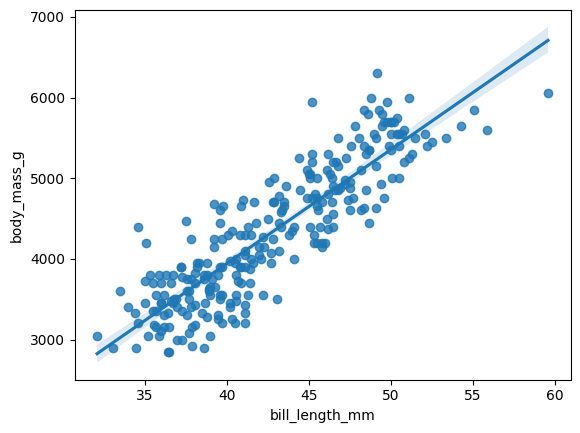

In [23]:
sns.regplot(x = "bill_length_mm", y = "body_mass_g", data = ols_data)

## Finish checking model assumptions

As you learned in previous videos, there are four main model assumptions for simple linear regression, in no particular order:
1. Linearity
2. Normality
3. Independent observations
4. Homoscedasticity

You already checked the linearity assumption by creating the scatterplot matrix. The independent observations assumption is more about data collection. There is no reason to believe that one penguin's body mass or bill length would be related to any other penguin's anatomical measurements. So we can check off assumptions 1 and 3.

The normality and homoscedasticity assumptions focus on the distribution of errors. Thus, you can only check these assumptions after you have constructed the model. To check these assumptions, you will check the residuals, as an approximation of the errors.

To more easily check the model assumptions and create relevant visualizations, you can first subset the X variable by isolating just the `bill_length_mm` column. Additionally, you can save the predicted values from the model using the `model.predict(X)` function.

In [24]:
# Subset X variable
X = ols_data["bill_length_mm"]

# Get predictions from model
fitted_values = model.predict(X)

Then, you can save the model residuals as a variable by using the `model.resid` attribute.

In [25]:
# Calculate residuals
residuals = model.resid

### Check the normality assumption

To check the normality assumption, you can create a histogram of the residuals using the `histplot()` function from the `seaborn` package.

From the below histogram, you may notice that the residuals are almost normally distributed. In this case, it is likely close enough that the assumption is met.

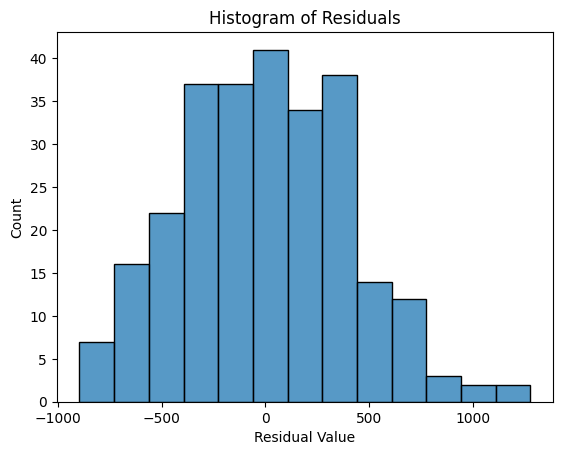

In [26]:
import matplotlib.pyplot as plt
fig = sns.histplot(residuals)
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")
plt.show()

Another way to check the normality function is to create a quantile-quantile or Q-Q plot. Recall that if the residuals are normally distributed, you would expect a straight diagonal line going from the bottom left to the upper right of the Q-Q plot. You can create a Q-Q plot by using the `qqplot` function from the `statsmodels.api` package.

The Q-Q plot shows a similar pattern to the histogram, where the residuals are mostly normally distributed, except at the ends of the distribution.

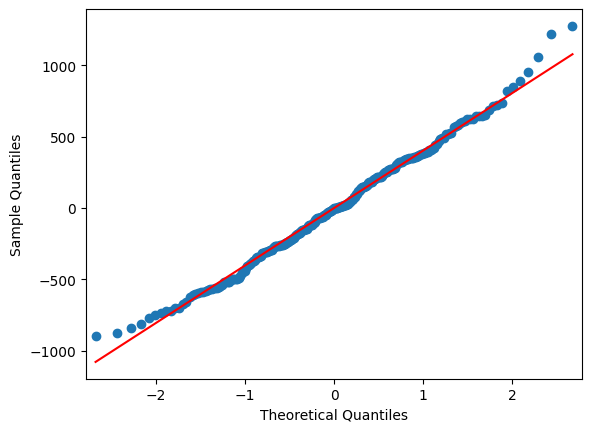

In [27]:

fig = sm.qqplot(model.resid, line = 's')
plt.show()

### Check the homoscedasticity assumption

Lastly, we have to check the homoscedasticity assumption. To check the homoscedasticity assumption, you can create a scatterplot of the fitted values and residuals. If the plot resembles a random cloud (i.e., the residuals are scattered randomly), then the assumption is likely met.

You can create one scatterplot by using the `scatterplot()` function from the `seaborn` package. The first argument is the variable that goes on the x-axis. The second argument is the variable that goes on the y-axis.

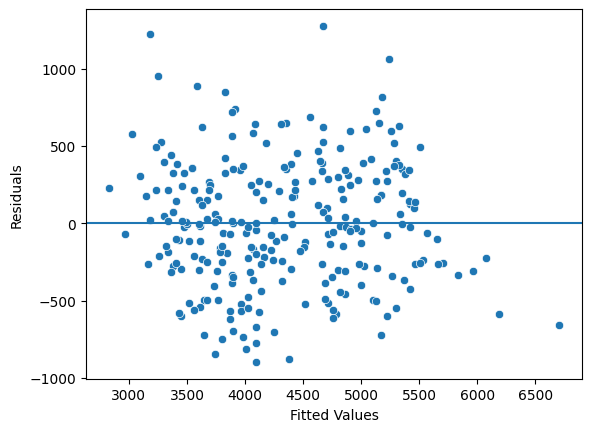

In [28]:
# Import matplotlib
import matplotlib.pyplot as plt
fig = sns.scatterplot(x=fitted_values, y=residuals)

# Add reference line at residuals = 0
fig.axhline(0)

# Set x-axis and y-axis labels
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")

# Show the plot
plt.show()

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.

You now understand how to build a simple linear regression model with Python. Going forward, you can start using simple linear regression models with your own datasets.

## Cleaned Up Process

In [29]:
dependent_var = 'body_mass_g'
independent_var = 'bill_length_mm'

ols_data = df[[independent_var, dependent_var]]
ols_formula = dependent_var + ' ~ ' + independent_var

ols_model = ols(formula=ols_formula, data=ols_data).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     874.3
Date:                Sat, 20 Jul 2024   Prob (F-statistic):           1.33e-85
Time:                        19:10:30   Log-Likelihood:                -1965.8
No. Observations:                 265   AIC:                             3936.
Df Residuals:                     263   BIC:                             3943.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1707.2919    205.640     -8.302      0.000   -2112.202   -1302.382
bill_length_mm   141.1904      4.775     29.569      0.000     131.788     150.592
==============================================================================
Omnibus:                        2.060   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                2.103
Skew:                           0.210   Prob(JB):                        0.349
Kurtosis:                       2.882   Cond. No.                         357.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

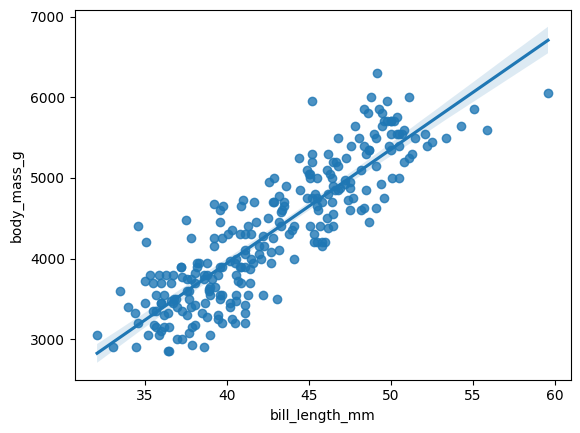

In [30]:
sns.regplot(x=independent_var, y=dependent_var, data = ols_data)

In [78]:
predictions = ols_model.predict(ols_data[independent_var])
residuals = ols_model.resid

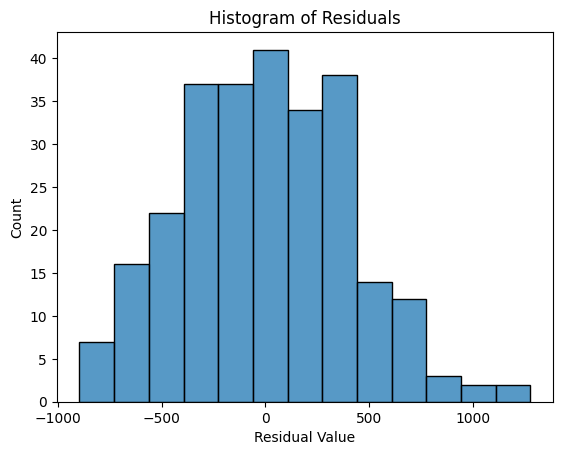

In [79]:
fig = sns.histplot(residuals)
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")
plt.show()

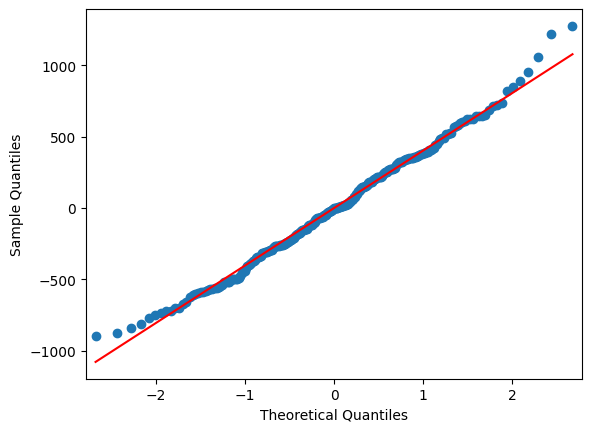

In [33]:
fig = sm.qqplot(residuals, line = 's')
plt.show()

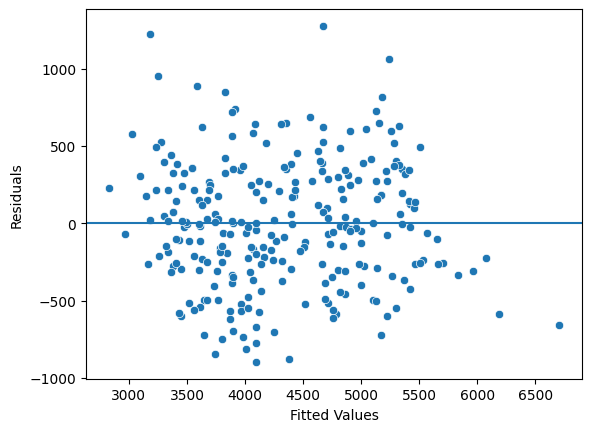

In [34]:
fig = sns.scatterplot(x=predictions, y=residuals)
fig.axhline(0)
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
plt.show()

## Manual Linear Regression

### Libraries

In [35]:
#from sklearn import linear_model
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression#, Ridge
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.svm import SVR
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Correlation

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            265 non-null    object 
 1   island             265 non-null    object 
 2   bill_length_mm     265 non-null    float64
 3   bill_depth_mm      265 non-null    float64
 4   flipper_length_mm  265 non-null    float64
 5   body_mass_g        265 non-null    float64
 6   sex                265 non-null    object 
dtypes: float64(4), object(3)
memory usage: 14.6+ KB


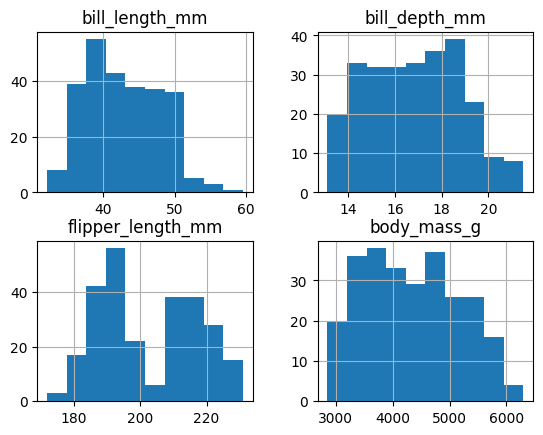

In [37]:
df.hist(); plt.show()

In [38]:
def df_correlation (df_test, types=['int64', 'float64'], percent=65, target=[]):
    list_corr = []
    percent = 10 if percent < 10 else percent
    df_corr = df_test[list(df.select_dtypes(include=types).columns)].corr()
    row_index = 0
    for row in df_corr.iterrows():
        if row[0] in target or len(target) == 0:
            col_index = 0
            for col in df_corr.columns:
                value = df_corr.loc[row[0], col]
                if (value > percent/100 or value < -percent/100) and value != 1.0:
                    if row_index <= col_index or len(target) != 0:
                        sign = '+' if value > 0 else ''
                        pearson_coef, p_value = stats.pearsonr(df[row[0]], df[col])
                        list_corr.append(f'{sign}{100*value:.1f}% {(p_value)}p [{row_index}] {row[0]} to [{col_index}] {col}') # {-math.log10(p_value):.0f}p
                col_index += 1
        row_index += 1  
    return list_corr

In [39]:
df_correlation(df, percent=10, target='body_mass_g')

['+87.7% 1.3299356031454668e-85p [3] body_mass_g to [0] bill_length_mm',
 '-48.3% 6.529653209580613e-17p [3] body_mass_g to [1] bill_depth_mm',
 '+88.4% 4.9661889408861744e-89p [3] body_mass_g to [2] flipper_length_mm']

### Model

In [40]:
model = LinearRegression()

In [41]:
x_data = df[['bill_length_mm']]
y_data = df['body_mass_g']

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=25/100)
model.fit(x_train, y_train)
y_hat_test = model.predict(x_test)
r_squared_test = model.score(x_test, y_test)
mse_test = mean_squared_error(y_test, y_hat_test)
print(f'{r_squared_test = :.0%} {mse_test = :.0f}')

r_squared_test = 79% mse_test = 150322


### Plot Prediction and Residuals

In [43]:
sign = '+' if model.intercept_ >= 0 else ''
equation = f'y = {model.coef_[0]:.0f}*x {sign}{model.intercept_:.0f}'
print(equation)

y = 138*x -1590


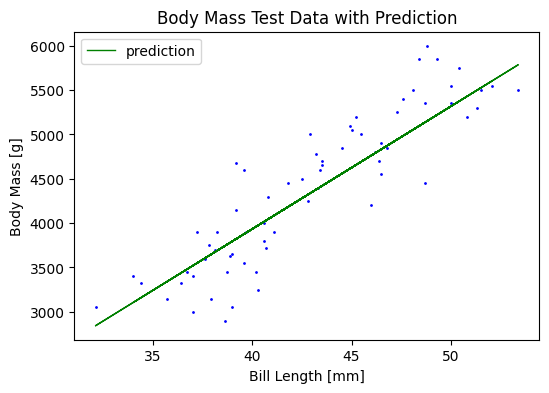

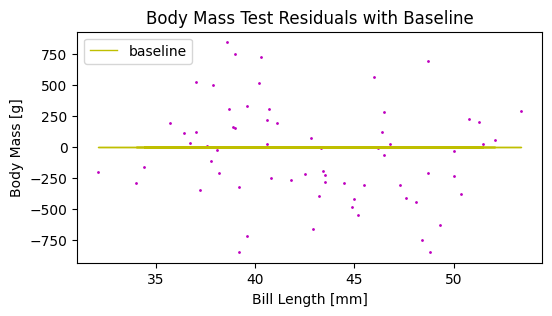

In [44]:
df_test = x_test[:]
df_test.insert(1, 'body_mass_g', y_test)
df_test.insert(2, 'prediction', y_hat_test)
df_test.insert(3, 'residual', (df_test.prediction - df_test.body_mass_g))
df_test.insert(4, 'baseline', df_test.bill_length_mm*0)

ax1 = df_test.plot(kind='scatter', x='bill_length_mm', y='body_mass_g', figsize=(8,5), style="o", s=1, c='b')
df_test.plot(kind='line', x='bill_length_mm', y='prediction', figsize=(6,4), lw=1, style='g-', ax=ax1)
ax1.annotate(equation, xy=(48,6500))
plt.title('Body Mass Test Data with Prediction')
plt.xlabel('Bill Length [mm]')
plt.ylabel('Body Mass [g]')

ax2 = df_test.plot(kind='scatter', x='bill_length_mm', y='residual', figsize=(8,5), style="o", s=1, c='m')
df_test.plot(kind='line', x='bill_length_mm', y='baseline', figsize=(6,3), lw=1, style='y-', ax=ax2)
plt.title('Body Mass Test Residuals with Baseline')
plt.xlabel('Bill Length [mm]')
plt.ylabel('Body Mass [g]')
plt.show()

In [49]:
df_test.head(1)

,bill_length_mm,body_mass_g,prediction,residual,baseline
159,48.4,5850.0,5095.060047,-754.939953,0.0


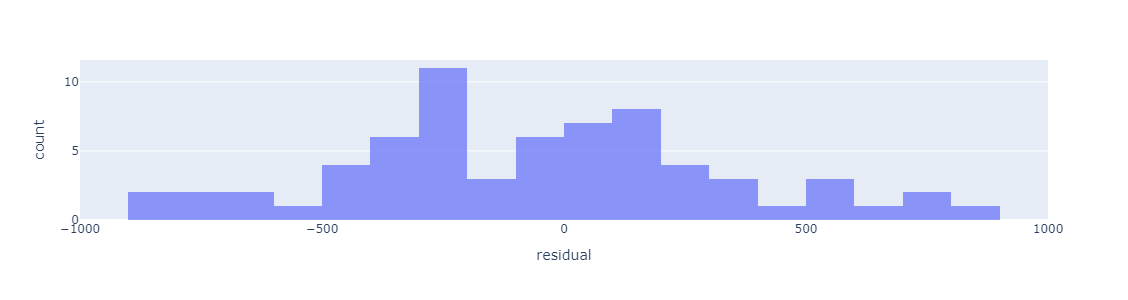

In [77]:
px.histogram(data_frame = df_test[['residual']], x = "residual", 
             range_x=(-1000,1000), nbins=18, barmode=['group','overlay','relative'][1],
             width=400, height=300, opacity=0.7)